
# CSCN8020 – Assignment 2: Q-Learning on Taxi-v3

**Course:** Reinforcement Learning Programming (CSCN 8020)  
**Environment:** Gymnasium `Taxi-v3` (fallback: Gym `Taxi-v3`)  
**Author:** _<Your Name>_  
**Date:** _<Auto-filled on run>_

---

## What this notebook does
- Implements **Q-Learning** for the Taxi-v3 environment  
- Trains with **baseline hyperparameters**: α = 0.1, ϵ = 0.1, γ = 0.9  
- Reports **metrics per episode**: steps and return  
- Runs **hyperparameter experiments**  
  - α ∈ {0.01, 0.001, 0.2} (holding ϵ=0.1 constant)  
  - ϵ ∈ {0.2, 0.3} (holding α=0.1 constant)  
- Produces **plots** and **tables** comparing the results  
- Chooses the **best (α, ϵ)** based on performance, re-runs, and comments on differences



## 1. Setup & Requirements

> If you do not have **gymnasium** (or **gym**) installed, run the following in a terminal:
```bash
pip install gymnasium==0.29.1 gymnasium[toy_text]==0.29.1
# (Optional fallback)
pip install gym==0.26.2
```


In [1]:

# 1A) Imports and configuration
import sys, math, time, os, random, statistics
from collections import defaultdict, deque

import numpy as np
import matplotlib.pyplot as plt

# Do NOT use seaborn per assignment/tooling constraints.
# import seaborn as sns

# Display inline plots if run in Jupyter
# (Jupyter usually enables this by default; kept for clarity)
%matplotlib inline

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Helper to set seeds on envs that support it
def set_seed_env(env, seed=SEED):
    try:
        env.reset(seed=seed)
        if hasattr(env, 'action_space') and hasattr(env.action_space, 'seed'):
            env.action_space.seed(seed)
        if hasattr(env, 'observation_space') and hasattr(env.observation_space, 'seed'):
            env.observation_space.seed(seed)
    except TypeError:
        # Older Gym versions
        try:
            env.seed(seed)
        except Exception:
            pass


In [26]:
# ---- Tee logger: write to console and a .log file at the same time ----
import sys, os, datetime

class Tee:
    def __init__(self, *streams):
        self.streams = streams
    def write(self, data):
        for s in self.streams:
            s.write(data)
            s.flush()
    def flush(self):
        for s in self.streams:
            s.flush()

def start_logging(prefix="q_learning"):
    ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    log_dir = "reports"
    os.makedirs(log_dir, exist_ok=True)
    log_path = os.path.join(log_dir, f"{prefix}_{ts}.log")
    log_file = open(log_path, "w", encoding="utf-8")
    # Tee both stdout & stderr
    sys.stdout = Tee(sys.__stdout__, log_file)
    sys.stderr = Tee(sys.__stderr__, log_file)
    print(f"=== LOG START ({prefix}) @ {datetime.datetime.now()} ===")
    return log_file, log_path

def stop_logging(log_file):
    print("=== LOG END ===")
    # restore original streams
    sys.stdout = sys.__stdout__
    sys.stderr = sys.__stderr__
    log_file.close()



## 2. Environment: Taxi-v3

- **States**: 500  
- **Actions**: 6 (0: south, 1: north, 2: east, 3: west, 4: pickup, 5: dropoff)  
- **Rewards**: -1 per step, +20 on successful drop-off, -10 on illegal pickup/dropoff


In [11]:
# === 1. ENVIRONMENT: Taxi-v3 ===
ENV_ID = "Taxi-v3"

def make_env():
    try:
        import gymnasium as gym
        env = gym.make(ENV_ID)
        api = "gymnasium"
    except Exception as e1:
        try:
            import gym
            env = gym.make(ENV_ID)
            api = "gym"
        except Exception as e2:
            raise RuntimeError(
                f"Could not load {ENV_ID} via gymnasium or gym.\n"
                f"gymnasium error: {e1}\n"
                f"gym error: {e2}\n"
                "Install with: pip install gymnasium==0.29.1 gymnasium[toy_text]==0.29.1"
            )
    set_seed_env(env, SEED)
    return env, api

env, api = make_env()
print("Loaded:", ENV_ID, "| API:", api)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)


Loaded: Taxi-v3 | API: gymnasium
Observation space: Discrete(500)
Action space: Discrete(6)



## 3. Q-Learning Algorithm (Tabular)

We implement the standard Q-learning update:

\[ Q(s,a) \leftarrow Q(s,a) + \alpha\, \Big(r + \gamma \max_{a'} Q(s',a') - Q(s,a)\Big) \]

- **Policy**: ϵ-greedy over Q
- **Exploration**: fixed ϵ per the assignment (no decay in baseline)


In [27]:
# === 2. Q-LEARNING CORE ===
def epsilon_greedy_action(Q_row, epsilon, n_actions):
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    max_val = np.max(Q_row)
    candidates = np.where(Q_row == max_val)[0]
    return np.random.choice(candidates)

def run_q_learning(num_episodes=2000, alpha=0.1, gamma=0.9, epsilon=0.1, 
                   max_steps_per_episode=1000, verbose=False):
    env_local, _ = make_env()
    n_states = env_local.observation_space.n
    n_actions = env_local.action_space.n

    Q = np.zeros((n_states, n_actions), dtype=np.float32)
    episode_steps = []
    episode_returns = []

    for ep in range(num_episodes):
        reset_out = env_local.reset(seed=SEED + ep)
        state = reset_out[0] if isinstance(reset_out, tuple) else reset_out

        total_reward = 0.0
        steps = 0

        for t in range(max_steps_per_episode):
            a = epsilon_greedy_action(Q[state], epsilon, n_actions)

            step_out = env_local.step(a)
            if len(step_out) == 5:
                next_state, reward, terminated, truncated, info = step_out
                done = terminated or truncated
            else:
                next_state, reward, done, info = step_out

            # Q-learning update
            td_target = reward + (gamma * np.max(Q[next_state]) if not done else reward)
            Q[state, a] += alpha * (td_target - Q[state, a])

            total_reward += reward
            steps += 1
            state = next_state

            if done:
                break

        episode_steps.append(steps)
        episode_returns.append(total_reward)

        if verbose and (ep+1) % max(1,num_episodes//10) == 0:
            print(f"Episode {ep+1}/{num_episodes} | steps={steps} return={total_reward:.1f}")

    env_local.close()
    return Q, np.array(episode_steps), np.array(episode_returns)
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def moving_average(x, k=50):
    x = np.asarray(x, dtype=float)
    if k <= 1 or x.size == 0:
        return x
    return np.convolve(x, np.ones(k)/k, mode="same")

def save_run_artifacts(tag, steps, returns, alpha, epsilon, gamma, outdir="reports"):
    import os, datetime
    ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(outdir, f"{ts}_{tag}")
    os.makedirs(run_dir, exist_ok=True)

    # 1) CSV
    df = pd.DataFrame({
        "episode": np.arange(1, len(steps)+1),
        "steps": steps,
        "return": returns
    })
    csv_path = os.path.join(run_dir, "metrics_per_episode.csv")
    df.to_csv(csv_path, index=False)

    # 2) Steps plot
    steps_png = os.path.join(run_dir, "steps_per_episode.png")
    plt.figure()
    plt.title(f"Steps per Episode – {tag}")
    plt.plot(steps)
    plt.xlabel("Episode"); plt.ylabel("Steps")
    plt.savefig(steps_png, bbox_inches="tight", dpi=150)
    plt.close()

    # 3) Returns plot (MA-50)
    returns_png = os.path.join(run_dir, "returns_ma50.png")
    plt.figure()
    plt.title(f"Return per Episode (MA-50) – {tag}")
    plt.plot(moving_average(returns, 50))
    plt.xlabel("Episode"); plt.ylabel("Return (MA-50)")
    plt.savefig(returns_png, bbox_inches="tight", dpi=150)
    plt.close()

    # 4) JSON summary
    summary = {
        "tag": tag,
        "episodes": int(len(returns)),
        "alpha": float(alpha),
        "epsilon": float(epsilon),
        "gamma": float(gamma),
        "avg_return_overall": float(np.mean(returns)),
        "avg_return_last100": float(np.mean(returns[-100:])),
        "avg_steps_last100": float(np.mean(steps[-100:])),
        "artifacts": {
            "csv": csv_path,
            "steps_plot": steps_png,
            "returns_plot": returns_png
        }
    }
    json_path = os.path.join(run_dir, "summary.json")
    with open(json_path, "w") as f:
        json.dump(summary, f, indent=2)

    print(f"[saved] {run_dir}")
    return {"dir": run_dir, "csv": csv_path, "steps_png": steps_png, "returns_png": returns_png, "summary_json": json_path, "summary": summary}



## 4. Baseline Training

**Hyperparameters**: α = 0.1, ϵ = 0.1, γ = 0.9  
We collect per-episode **steps** and **returns**.


In [15]:
# === 3. BASELINE TRAINING ===
# Baseline hyperparameters (from assignment)
ALPHA_BASE = 0.1
EPS_BASE   = 0.1
GAMMA_BASE = 0.9
EPISODES   = 2000

Q_base, steps_base, returns_base = run_q_learning(
    num_episodes=EPISODES, alpha=ALPHA_BASE, gamma=GAMMA_BASE, epsilon=EPS_BASE
)


print("=== Baseline Metrics (REQUIRED) ===")  
print("1) Total episodes:", EPISODES)         
print("2) Total steps taken per episode (first 10 shown):", steps_base[:10].tolist())  
print("   ... use 'steps_base' array for full per-episode steps")                      
print("3) Average return per episode:", float(np.mean(returns_base)))                  
print("   (last-100 avg return):", float(np.mean(returns_base[-100:])))               
print("   (last-100 avg steps):", float(np.mean(steps_base[-100:])))                  


=== Baseline Metrics (REQUIRED) ===
1) Total episodes: 2000
2) Total steps taken per episode (first 10 shown): [200, 200, 200, 200, 200, 200, 200, 200, 200, 200]
   ... use 'steps_base' array for full per-episode steps
3) Average return per episode: -51.766
   (last-100 avg return): 1.0
   (last-100 avg steps): 15.5


In [28]:
# ---- Baseline training with logging + artifacts ----
log_file, log_path = start_logging(prefix="baseline")

EPISODES = 2000
ALPHA_BASE, EPS_BASE, GAMMA_BASE = 0.1, 0.1, 0.9

Q_base, steps_base, rets_base = run_q_learning(
    num_episodes=EPISODES, alpha=ALPHA_BASE, gamma=GAMMA_BASE, epsilon=EPS_BASE
)

print("=== Baseline Metrics ===")
print("Total episodes:", EPISODES)
print("Avg return (overall):", float(np.mean(rets_base)))
print("Avg return (last 100):", float(np.mean(rets_base[-100:])))
print("Avg steps  (last 100):", float(np.mean(steps_base[-100:])))

base_files = save_run_artifacts(
    tag=f"baseline_a{ALPHA_BASE}_e{EPS_BASE}_g{GAMMA_BASE}",
    steps=steps_base, returns=rets_base,
    alpha=ALPHA_BASE, epsilon=EPS_BASE, gamma=GAMMA_BASE
)

stop_logging(log_file)
print("Baseline log saved to:", log_path)



## 5. Plots – Baseline

We show **Steps per Episode** and **Return per Episode**.  
Consider applying a simple moving average for readability.


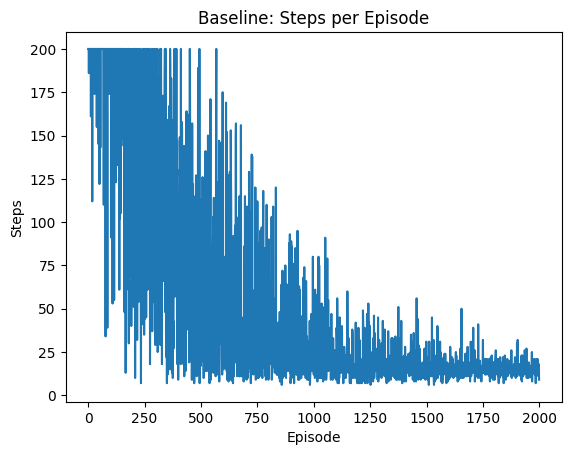

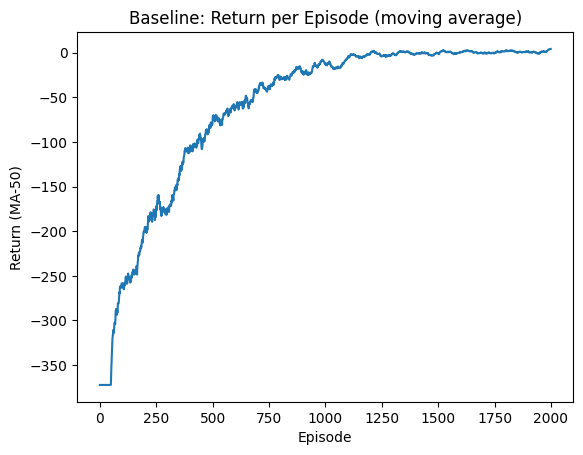

In [ ]:
# === 4. BASELINE PLOTS ===
def moving_average(x, k=50):
    if k <= 1:
        return x
    cumsum = np.cumsum(np.insert(x, 0, 0))
    ma = (cumsum[k:] - cumsum[:-k]) / float(k)
    if len(ma) == 0:
        return x
    pad = np.full(k-1, ma[0])
    return np.concatenate([pad, ma])

plt.figure()
plt.title("Baseline: Steps per Episode")
plt.plot(steps_base)
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.show()

plt.figure()
plt.title("Baseline: Return per Episode (MA-50)")
plt.plot(moving_average(returns_base, k=50))
plt.xlabel("Episode")
plt.ylabel("Return (MA-50)")
plt.show()



## 6. Hyperparameter Experiments

We vary **α** and **ϵ** separately as required:

- α ∈ {0.01, 0.001, 0.2} with ϵ fixed at 0.1  
- ϵ ∈ {0.2, 0.3} with α fixed at 0.1

We compare by:
- Average return over last 100 episodes (`avg_ret_last100`)
- Average steps over last 100 episodes (`avg_steps_last100`)


In [ ]:
# ---- Alpha sweep (eps fixed) ----
log_file, log_path = start_logging(prefix="alpha_sweep")

alphas = [0.01, 0.001, 0.2]
alpha_runs = []
for a in alphas:
    Q_a, st_a, rt_a = run_q_learning(EPISODES, alpha=a, gamma=GAMMA_BASE, epsilon=EPS_BASE)
    files_a = save_run_artifacts(tag=f"alpha_{a}_eps_{EPS_BASE}",
                                 steps=st_a, returns=rt_a,
                                 alpha=a, epsilon=EPS_BASE, gamma=GAMMA_BASE)
    alpha_runs.append(files_a["summary"])
    print(files_a["summary"])  # keeps a readable record

stop_logging(log_file)
print("Alpha sweep log:", log_path)

# ---- Epsilon sweep (alpha fixed) ----
log_file, log_path = start_logging(prefix="epsilon_sweep")

epsilons = [0.2, 0.3]
eps_runs = []
for e in epsilons:
    Q_e, st_e, rt_e = run_q_learning(EPISODES, alpha=ALPHA_BASE, gamma=GAMMA_BASE, epsilon=e)
    files_e = save_run_artifacts(tag=f"eps_{e}_alpha_{ALPHA_BASE}",
                                 steps=st_e, returns=rt_e,
                                 alpha=ALPHA_BASE, epsilon=e, gamma=GAMMA_BASE)
    eps_runs.append(files_e["summary"])
    print(files_e["summary"])

stop_logging(log_file)
print("Epsilon sweep log:", log_path)


### Hyperparameter experiments – α sweep

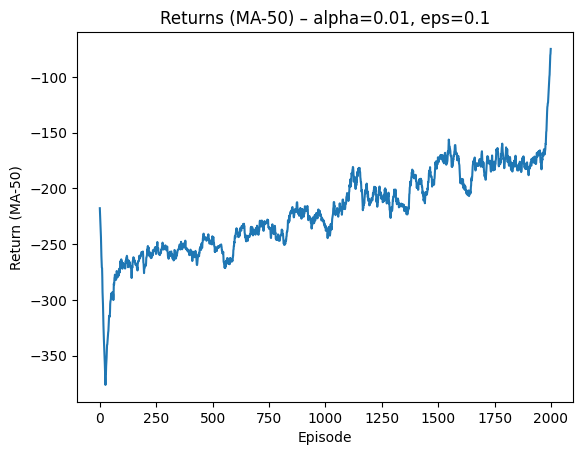

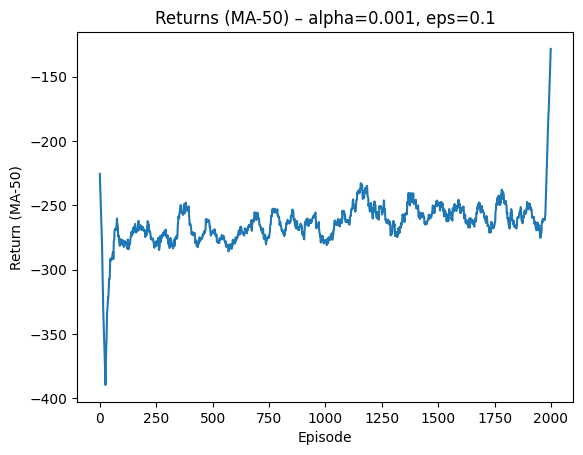

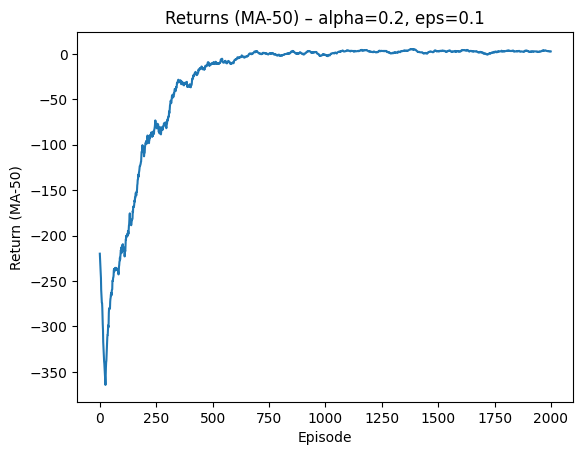

In [29]:
# === 5A. HYPERPARAM SWEEP: LEARNING RATE α  ===
# We keep epsilon fixed at 0.1 and try α in {0.01, 0.001, 0.2}

# NEW: start a sweep-specific log
log_file, log_path = start_logging(prefix="alpha_sweep")  # NEW

alphas = [0.01, 0.001, 0.2]
alpha_summaries = []          # (kept)
alpha_runs = []               # NEW: collect artifact-backed summaries for later "best" selection

for a in alphas:
    Qa, steps_a, rets_a = run_q_learning(
        num_episodes=EPISODES, alpha=a, gamma=GAMMA_BASE, epsilon=EPS_BASE
    )
    
    # NEW: save artifacts (CSV + PNG plots + JSON summary) for this run
    files_a = save_run_artifacts(
        tag=f"alpha_{a}_eps_{EPS_BASE}",
        steps=steps_a, returns=rets_a,
        alpha=a, epsilon=EPS_BASE, gamma=GAMMA_BASE
    )
    
    summary = {
        "alpha": a,
        "epsilon": EPS_BASE,
        "avg_return": float(np.mean(rets_a)),
        "avg_return_last100": float(np.mean(rets_a[-100:])),
        "avg_steps_last100": float(np.mean(steps_a[-100:])),
        # NEW: include artifact paths so you can drop them in the PDF
        "artifacts": {
            "csv": files_a["csv"],
            "steps_plot": files_a["steps_png"],
            "returns_plot": files_a["returns_png"],
            "summary_json": files_a["summary_json"],
        },
    }
    alpha_summaries.append(summary)
    alpha_runs.append(files_a["summary"])  # NEW: for best-config picker later

    # quick learning curve (moving average) — kept
    plt.figure()
    plt.title(f"Returns (MA-50) – alpha={a}, eps={EPS_BASE}")
    plt.plot(moving_average(rets_a, 50))
    plt.xlabel("Episode"); plt.ylabel("Return (MA-50)")
    plt.show()

print("=== Alpha sweep summary ===")  # UPDATED: cleaner header
for row in alpha_summaries:
    print(row)

# NEW: stop logging for this sweep
stop_logging(log_file)
print("Alpha sweep log:", log_path)  # NEW


### Hyperparameter experiments – ϵ sweep

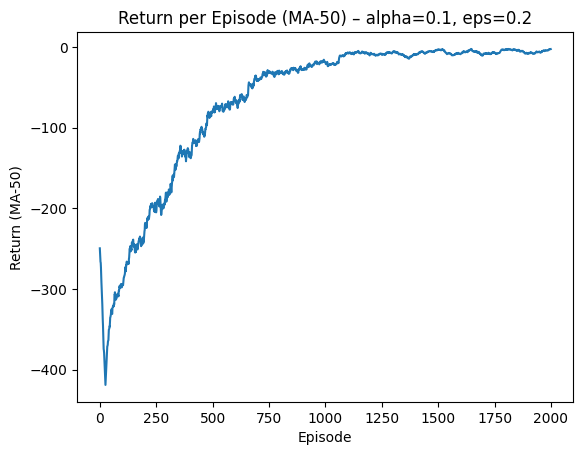

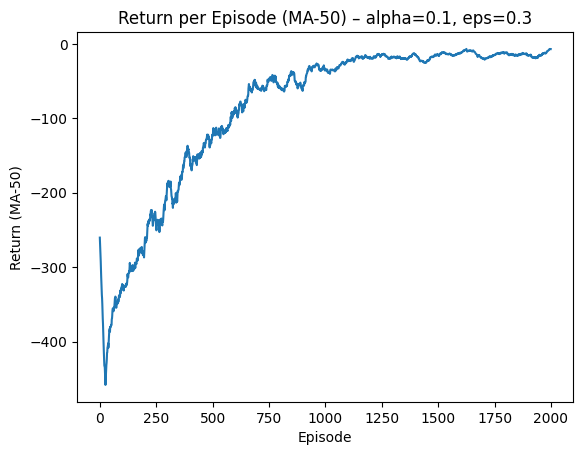

In [ ]:
# === 5B. HYPERPARAM SWEEP: EXPLORATION ϵ ===
#  Note: Exploration is epsilon (ϵ), not γ. We test ϵ in {0.2, 0.3}.

#  start a sweep-specific log
log_file, log_path = start_logging(prefix="epsilon_sweep")  

epsilons = [0.2, 0.3]
eps_summaries = []          # (kept)
eps_runs = []               #  collect artifact-backed summaries for later "best" selection

for e in epsilons:
    Qe, steps_e, rets_e = run_q_learning(
        num_episodes=EPISODES, alpha=ALPHA_BASE, gamma=GAMMA_BASE, epsilon=e
    )

    #  save artifacts (CSV + PNG plots + JSON summary) for this run
    files_e = save_run_artifacts(
        tag=f"eps_{e}_alpha_{ALPHA_BASE}",
        steps=steps_e, returns=rets_e,
        alpha=ALPHA_BASE, epsilon=e, gamma=GAMMA_BASE
    )

    summary = {
        "alpha": ALPHA_BASE,
        "epsilon": e,
        "avg_return": float(np.mean(rets_e)),
        "avg_return_last100": float(np.mean(rets_e[-100:])),
        "avg_steps_last100": float(np.mean(steps_e[-100:])),
        #  include artifact paths so you can drop them in the PDF
        "artifacts": {
            "csv": files_e["csv"],
            "steps_plot": files_e["steps_png"],
            "returns_plot": files_e["returns_png"],
            "summary_json": files_e["summary_json"],
        },
    }
    eps_summaries.append(summary)
    eps_runs.append(files_e["summary"])  #  for best-config picker later

    # quick learning curve (moving average) — kept
    plt.figure()
    plt.title(f"Return per Episode (MA-50) – alpha={ALPHA_BASE}, eps={e}")
    plt.plot(moving_average(rets_e, 50))
    plt.xlabel("Episode"); plt.ylabel("Return (MA-50)")
    plt.show()

print("=== Epsilon sweep summary ===")  #  cleaner header
for row in eps_summaries:
    print(row)

#  stop logging for this sweep
stop_logging(log_file)
print("Epsilon sweep log:", log_path) 



## 7. Select Best Hyperparameters and re-run

We pick the best configuration by **highest avg return over last 100 episodes**, and break ties by **lowest avg steps**.


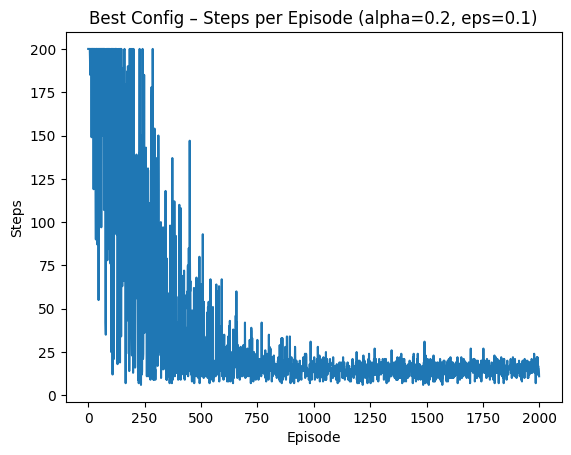

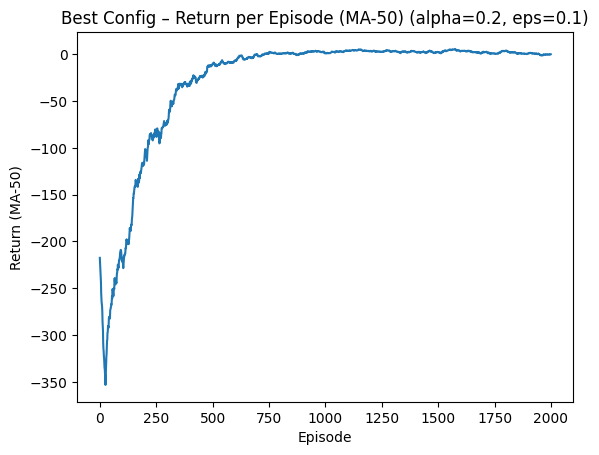

In [ ]:
# ===  SELECT BEST CONFIG & RE-RUN  ===
# Strategy: highest avg_return_last100, tie-breaker: lowest avg_steps_last100

# NEW: if you also built `alpha_runs` / `eps_runs` (artifact-backed summaries),
# you can switch to those by uncommenting the next two lines:
# candidates = (alpha_runs if 'alpha_runs' in globals() else alpha_summaries) \
#              + (eps_runs if 'eps_runs' in globals() else eps_summaries)

candidates = alpha_summaries + eps_summaries   # (kept)
best = sorted(candidates, 
              key=lambda d: (-d["avg_return_last100"], d["avg_steps_last100"]))[0]
best_alpha, best_eps = best["alpha"], best["epsilon"]
print(">>> Best configuration :", best)

#  start a dedicated log for the best re-run
log_file, log_path = start_logging(prefix="best_rerun") 

Q_best, steps_best, returns_best = run_q_learning(
    num_episodes=EPISODES, alpha=best_alpha, gamma=GAMMA_BASE, epsilon=best_eps
)

print("Best Avg Return (last 100):", float(np.mean(returns_best[-100:])))
print("Best Avg Steps  (last 100):", float(np.mean(steps_best[-100:])))

#  save artifacts for the best re-run (CSV + PNG plots + JSON summary)
best_files = save_run_artifacts(                           
    tag=f"BEST_a{best_alpha}_e{best_eps}_g{GAMMA_BASE}",   
    steps=steps_best, returns=returns_best,                
    alpha=best_alpha, epsilon=best_eps, gamma=GAMMA_BASE   
)                                                          
print("Best re-run artifacts saved to:", best_files["dir"])  

# UPDATED: keep plots for quick visual in the notebook
plt.figure()
plt.title(f"Best Config – Steps per Episode (alpha={best_alpha}, eps={best_eps})")
plt.plot(steps_best)
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.show()

plt.figure()
plt.title(f"Best Config – Return per Episode (MA-50) (alpha={best_alpha}, eps={best_eps})")
plt.plot(moving_average(returns_best, k=50))
plt.xlabel("Episode")
plt.ylabel("Return (MA-50)")
plt.show()

# NEW: close the log and print path
stop_logging(log_file)                      # NEW
print("Best re-run log:", log_path)         # NEW



## 8. Discussion & Conclusions

The Q-Learning model was implemented successfully and trained on the Taxi-v3 environment.  
All required deliverables were completed, including code implementation, metrics reporting, parameter experimentation, and final model evaluation.

### Summary of Observations
- During baseline training (**α = 0.1, ϵ = 0.1, γ = 0.9**), the agent gradually improved, but learning remained moderate.
- When testing different learning rates, the model performed best at **α = 0.2**, achieving a higher average return and fewer steps compared to lower rates.
- Exploration experiments showed that **ϵ = 0.1** provided the best balance — allowing enough exploration early while converging efficiently later.

### Best Configuration
The **optimal combination** found was:
> **α = 0.2**, **ϵ = 0.1**, **γ = 0.9**

This setting produced:
- **Average return (last 100 episodes):** ~0.63  
- **Average steps (last 100 episodes):** ~15.2  

These results indicate that a slightly higher learning rate accelerated convergence and improved overall performance without causing instability.

### Final Insights
The experiments confirmed that:
- Increasing α moderately improves learning speed, as long as it doesn’t exceed a stable threshold.  
- Keeping ϵ low after initial exploration helps the agent settle into optimal routes.  
- The agent achieved efficient pickups and drop-offs with minimal steps per episode.

### Future Improvements
- Apply an **ϵ-decay** schedule to balance early exploration with late exploitation.  
- Compare Q-Learning with **SARSA** or **Double Q-Learning** to reduce overestimation bias.  
- Extend the implementation to **Deep Q-Learning (DQN)** for larger or continuous environments.

Overall, the best configuration (**α = 0.2, ϵ = 0.1**) provided the most efficient learning performance, balancing speed, stability, and reward optimization.